# Andrej Karpathy's /makemore

#### Reference
https://www.youtube.com/watch?v=TCH_1BHY58I

https://github.com/karpathy/makemore

With Bigram char level model, we only used two chars which created a 27x27 data space. if we move deeper in this approach to enhance the loss function and the model itself, the only avenue was to explor adding more dimensions, i.e. 27x27x27. however this path suddenly explodes in terms of data and parameters that we want to use for this model.

Therefore, we need to explore a better model.

## Multi Layer Perceptron (MLP)
#### Bengio et al. 2003

This is another char level model to predict the next char, however the paper is based on word predictions. 

The proposed approach is to take 'w' number of words, and associate to each word, 'm' number of feature vectors. Meaning that, each word is embedded in a 'm' dimensional feature space. Initially these words are initialized randomly but later we'll tune them using backpropagation. 

To imagine this approach, think about words that are similar or synonyms. They will end up in the same part of the space. And those that are different will be separated. 

The modeling approach is similar to the NN approach for Bigram. They use multi-layer NN to predict the next words, given the previous words. To train the NN, they ```maximize the log-likelihood of the training data```.

Let's look at an ```example``` for this approach. Assume, we are not given the sentence "A dog was running in a room". But now for testing the model we are providing it with "A dog was running in a ..." and expecting the model to fill in the blank. Since it hasn't seen this exact sentence, we call it, ```out of distribution```. However, MLP doesn't need to have seen the exact words to predict 'room' for the blank. Because it might have seen "The dog was running in a room" and based on the learnings, it has put the embeddings of 'The' and 'A' near by each other in the space. So now that we are asking it to fill the blank based on "A dog was running in a ...", it will match it up with "The dog was running in a room". This is called ```knowledge transfer```.

Let's look at the ```architecture``` of this approach. 

Assume the NN's input, takes 3 previous-words. And the output is the fourth word. Each of the incoming words, will go through a look-up table, to match up the corresponding embedding ('m' feature vector) for that word. So there will be $3 \times m$ neurons holding the 3 words. 

Then we need to build a hidden layer. The size is a ```hyper-parameter```. Meaning that, we need to come up with the right size based on try-error. So all the input neurons goes into the hidden layer. And there will be a ```tanh``` function applied for non-linearity. 

The output layer is a huge one, because the number of neurons is equivalent to $w$, the number of words in our data set. All the neurons in the hidden layer are connected to the output neurons. That's why there will be lots of params in between these two layers, and therefore, it's going to be computationally expensive. On top of the output layer we have ```softmax``` (exponentiate the logits and normalize, so that it will sum up to 1). This way, we'll get a nice probability distribution for the next word in the sequence. 

During training, because we have xs and ys, we will get the probability for each x and minimize the NN's loss by improving the parameters. The optimization used here is also ```backpropagation```.

In [185]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [186]:
import os

# read from another package while we are in a separate package
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
file_path = os.path.join(parent_directory, 'opensource/makemore', 'names.txt')

words = open(file_path, 'r').read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [187]:
# build the vocabulary of chars and mappings to/from integers
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i,s in enumerate(chars)}
s2i['.'] = 0
i2s = {i:s for s,i in s2i.items()}
print(i2s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


#### build the dataset

In [188]:
# build the dataset

block_size = 3 # context length: how many chars do we take to predict the next char, 4-th one
X, Y = [], []
for w in words[:5]: # the examples we can generate from the first 5 words
    print(w)
    context = [0] * block_size
    for ch in w + '.': # we are padding with dots, because if the word doesn't have enough chars to cover for our block_size, we'll have something to build
        ix = s2i[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(i2s[i] for i in context), '--->', i2s[ix])
        context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [189]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [190]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

#### Build The Embeddings

the paper used 70000 words with 30 embeddings. we have 27 chars, so we'll go with 2 embeddings.

In [191]:
C = torch.randn((27, 2))
C[5]

tensor([-1.5356, -1.1602])

In [192]:
# retrieve embeddings with a list of lookups
C[[5,6,8]]

tensor([[-1.5356, -1.1602],
        [-1.9636, -1.2327],
        [-0.3581,  0.4690]])

In [193]:
# therefore this works
emb = C[X]
emb

tensor([[[-0.7441, -1.3213],
         [-0.7441, -1.3213],
         [-0.7441, -1.3213]],

        [[-0.7441, -1.3213],
         [-0.7441, -1.3213],
         [-1.5356, -1.1602]],

        [[-0.7441, -1.3213],
         [-1.5356, -1.1602],
         [-0.4779,  0.7886]],

        [[-1.5356, -1.1602],
         [-0.4779,  0.7886],
         [-0.4779,  0.7886]],

        [[-0.4779,  0.7886],
         [-0.4779,  0.7886],
         [ 3.1316, -0.3591]],

        [[-0.7441, -1.3213],
         [-0.7441, -1.3213],
         [-0.7441, -1.3213]],

        [[-0.7441, -1.3213],
         [-0.7441, -1.3213],
         [-0.8766, -0.7644]],

        [[-0.7441, -1.3213],
         [-0.8766, -0.7644],
         [-0.3467,  1.6859]],

        [[-0.8766, -0.7644],
         [-0.3467,  1.6859],
         [ 0.3724, -0.7340]],

        [[-0.3467,  1.6859],
         [ 0.3724, -0.7340],
         [-0.1864,  0.4035]],

        [[ 0.3724, -0.7340],
         [-0.1864,  0.4035],
         [ 0.3724, -0.7340]],

        [[-0.1864,  0

#### hidden layer

In [194]:
hidden_layer_hyperparameter_size = 100
num_of_words = 3
num_of_embeddings = 2
num_of_inputs = num_of_words * num_of_embeddings

w1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size))
b1 = torch.randn((hidden_layer_hyperparameter_size))



In [195]:
X.shape

torch.Size([32, 3])

In [196]:
C.shape

torch.Size([27, 2])

In [197]:
emb.shape

torch.Size([32, 3, 2])

In [198]:
w1.shape

torch.Size([6, 100])

wee want to setup the tensor's shapes in such a way that ```emb @ w1 + b1``` would work.

http://blog.ezyang.com/2019/05/pytorch-internals/


In [199]:
x_size = emb.shape[0] # or use -1 for pytorch to figure it out
emb.view(x_size, num_of_inputs) @ w1 + b1

tensor([[-1.1063, -0.1956,  1.0527,  ...,  3.4857, -2.3596, -0.0303],
        [-1.6774, -0.0384,  0.9194,  ...,  4.7999, -1.2727,  0.3032],
        [-2.6512, -0.2633,  1.5187,  ...,  4.3099, -1.5200,  0.9739],
        ...,
        [ 0.3280,  1.0885,  2.9605,  ..., -0.9545, -0.8164,  0.6726],
        [ 2.0355, -0.5030, -0.1003,  ...,  0.7610, -2.7609, -2.6052],
        [ 1.9825, -0.9363,  2.6258,  ..., -7.4045, -5.4526, -1.3877]])

In [200]:
# hidden layer
h = torch.tanh(emb.view(-1, num_of_inputs) @ w1 + b1) # added tanh to bring all the values between -1 and 1 for non-linearity
h 

tensor([[-0.8027, -0.1932,  0.7828,  ...,  0.9981, -0.9823, -0.0303],
        [-0.9325, -0.0384,  0.7256,  ...,  0.9999, -0.8545,  0.2942],
        [-0.9901, -0.2573,  0.9085,  ...,  0.9996, -0.9087,  0.7504],
        ...,
        [ 0.3167,  0.7963,  0.9946,  ..., -0.7418, -0.6731,  0.5867],
        [ 0.9664, -0.4645, -0.0999,  ...,  0.6417, -0.9920, -0.9891],
        [ 0.9628, -0.7335,  0.9896,  ..., -1.0000, -1.0000, -0.8827]])

#### output layer

In [201]:
# output layer
w2 = torch.randn((hidden_layer_hyperparameter_size, 27))
b2 = torch.randn((27))
logits = h @ w2 + b2
logits.shape

torch.Size([32, 27])

In [202]:
counts = logits.exp() # get fake counts
probs = counts / counts.sum(1, keepdim=True) # normalize to get the probabilities
probs.shape


torch.Size([32, 27])

In [203]:
# proof of normalized probs is to check if every row sums up to =1
probs[0].sum()

tensor(1.0000)

In [204]:
probs[torch.arange(32), Y]

tensor([2.0731e-06, 2.2220e-02, 4.7492e-13, 4.4023e-05, 1.0357e-08, 2.3559e-06,
        8.3836e-01, 5.9869e-13, 4.3647e-05, 5.8108e-06, 3.7307e-08, 8.4064e-07,
        8.9202e-08, 7.5333e-10, 2.5995e-08, 5.3484e-06, 3.4731e-02, 6.3238e-07,
        8.3018e-09, 2.3675e-09, 5.5572e-07, 4.0001e-12, 1.1031e-09, 3.7042e-02,
        1.3796e-11, 6.1066e-05, 1.4449e-08, 6.8229e-05, 2.3223e-07, 1.3255e-02,
        3.0096e-09, 4.0769e-07])

#### Training on Small Dataset (over-fitting)

we haven't trained the NN yet so the probabilities are far from 1.

In [205]:
# we need to minimize this loss
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(14.7486)

let's put everything together

In [206]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [207]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [208]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp() # (32, 27)
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697, grad_fn=<NegBackward0>)

instead of using the above code we can also use pytorch library to arrive at the same loss, which is more efficient. 

In [209]:
F.cross_entropy(logits, Y)

tensor(17.7697, grad_fn=<NllLossBackward0>)

let's setup the training procedure

In [210]:
for _ in range(100):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data.add_(-0.1 * p.grad)

loss ->  17.769712448120117
loss ->  13.656402587890625
loss ->  11.298768997192383
loss ->  9.4524564743042
loss ->  7.984262943267822
loss ->  6.891320705413818
loss ->  6.100014686584473
loss ->  5.452036380767822
loss ->  4.898151874542236
loss ->  4.414663791656494
loss ->  3.985849380493164
loss ->  3.6028308868408203
loss ->  3.2621421813964844
loss ->  2.961381435394287
loss ->  2.6982975006103516
loss ->  2.469712734222412
loss ->  2.271660566329956
loss ->  2.101283550262451
loss ->  1.9571772813796997
loss ->  1.8374857902526855
loss ->  1.7380967140197754
loss ->  1.653511643409729
loss ->  1.5790899991989136
loss ->  1.5117664337158203
loss ->  1.449604868888855
loss ->  1.3913118839263916
loss ->  1.3359922170639038
loss ->  1.2830528020858765
loss ->  1.2321910858154297
loss ->  1.18338143825531
loss ->  1.136798620223999
loss ->  1.092664122581482
loss ->  1.051092267036438
loss ->  1.0120269060134888
loss ->  0.9752703309059143
loss ->  0.940556526184082
loss ->  0.907

so far we reached above optimized loss with 5 words and 32 examples. so let's pull in all the data.

#### Training On Full Dataset

In [211]:
# build the dataset

block_size = 3 # context length: how many chars do we take to predict the next char, 4-th one
X, Y = [], []
for w in words: # the examples we can generate from the first 5 words
    context = [0] * block_size
    for ch in w + '.': # we are padding with dots, because if the word doesn't have enough chars to cover for our block_size, we'll have something to build
        ix = s2i[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [212]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [213]:
for _ in range(100):
    # forward pass
    emb = C[X] 
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y)
    print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data.add_(-0.1 * p.grad)

loss ->  19.505229949951172
loss ->  17.084484100341797
loss ->  15.776531219482422
loss ->  14.833340644836426
loss ->  14.002605438232422
loss ->  13.253263473510742
loss ->  12.57991886138916
loss ->  11.983102798461914
loss ->  11.47049331665039
loss ->  11.05185604095459
loss ->  10.709586143493652
loss ->  10.407631874084473
loss ->  10.127808570861816
loss ->  9.864364624023438
loss ->  9.614501953125
loss ->  9.376439094543457
loss ->  9.148944854736328
loss ->  8.931110382080078
loss ->  8.722230911254883
loss ->  8.521748542785645
loss ->  8.329227447509766
loss ->  8.144325256347656
loss ->  7.966791152954102
loss ->  7.796450614929199
loss ->  7.633184909820557
loss ->  7.476907730102539
loss ->  7.327521800994873
loss ->  7.184885025024414
loss ->  7.04879093170166
loss ->  6.918952465057373
loss ->  6.795018196105957
loss ->  6.676603317260742
loss ->  6.563317775726318
loss ->  6.454790115356445
loss ->  6.350668907165527
loss ->  6.250643253326416
loss ->  6.15443229675

#### Mini-Batch

The reason why above training takes a lot of time is that, it's doing a forward and backward pass on a large dataset. To optimize the training process we introduce mini-batches. 

With mini-batch, we do the forward and backward passes on a smaller dataset. Once optimized we move to another batch for training and optimizing the loss.

In [214]:
for _ in range(1000):

    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # 32 random integers between 0 and X.shape[0]. this will make the batch size 32

    # forward pass
    emb = C[X[ix]] # instead of sending the entire X for mapping, we can only iterate over the batch size
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) # labels are also only for the batch size too
    print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data.add_(-0.1 * p.grad)

loss ->  3.3262014389038086
loss ->  3.990469455718994
loss ->  4.568592071533203
loss ->  3.4572391510009766
loss ->  3.057582139968872
loss ->  2.968867540359497
loss ->  4.13862943649292
loss ->  3.8914408683776855
loss ->  4.303944110870361
loss ->  3.335280179977417
loss ->  3.6771888732910156
loss ->  3.1159186363220215
loss ->  3.814709424972534
loss ->  3.5316100120544434
loss ->  3.5149285793304443
loss ->  2.8092126846313477
loss ->  3.787062883377075
loss ->  3.6012444496154785
loss ->  3.673198699951172
loss ->  3.9197616577148438
loss ->  4.388669490814209
loss ->  3.146528959274292
loss ->  3.1732144355773926
loss ->  3.5235331058502197
loss ->  3.263209819793701
loss ->  3.5374042987823486
loss ->  3.11478853225708
loss ->  3.938927173614502
loss ->  4.150063991546631
loss ->  2.880949020385742
loss ->  3.6969046592712402
loss ->  3.147365093231201
loss ->  3.9225196838378906
loss ->  3.6787753105163574
loss ->  3.236668586730957
loss ->  3.5371813774108887
loss ->  3.90

now you can see that thee training is much faster and therefore, you can afford to increase the iterations for further minimizing the loss.

#### Learning Rate

How do you determine the learning rate? How do you know if it's too small (moving too slowly towards an optimized loss), or it's too big (over-stepping and missing the optimized loss)?

One way is to find the min and max range, first. You can provide -0.0001 or lower and find the value that demonstrates a reasonable decrease in the loss. Then find a big number with the same analogy. Based in this, we can see that, the optimized learning rate should be between -0.001 and -1.

We can use pytorch's library to create a linear array of learning rates between these two numbers for, say 1000 steps.

In [215]:
lre = torch.linspace(-3, 0, 1000) # linear rate exponential
lrs = 10**lre # learning rates: 10^-3 = 0.001 and 10^0 = 1
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

now let's reset everything and iterate through possible learning rates to find the best match

In [216]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # number of parameters in total

3481

loss ->  20.64219856262207
loss ->  21.367820739746094
loss ->  21.69013786315918
loss ->  21.809776306152344
loss ->  22.773935317993164
loss ->  19.684816360473633
loss ->  19.62133026123047
loss ->  17.392841339111328
loss ->  18.789398193359375
loss ->  17.845462799072266
loss ->  18.572010040283203
loss ->  19.658260345458984
loss ->  15.919187545776367
loss ->  20.390913009643555
loss ->  20.20417594909668
loss ->  17.795604705810547
loss ->  16.08721160888672
loss ->  18.807891845703125
loss ->  16.974454879760742
loss ->  20.22616958618164
loss ->  16.124752044677734
loss ->  19.723262786865234
loss ->  18.266300201416016
loss ->  20.413724899291992
loss ->  18.127092361450195
loss ->  18.871150970458984
loss ->  18.110036849975586
loss ->  18.99818229675293
loss ->  20.89285659790039
loss ->  19.351041793823242
loss ->  17.51865577697754
loss ->  20.744159698486328
loss ->  18.014678955078125
loss ->  18.715267181396484
loss ->  19.912965774536133
loss ->  15.886554718017578
l

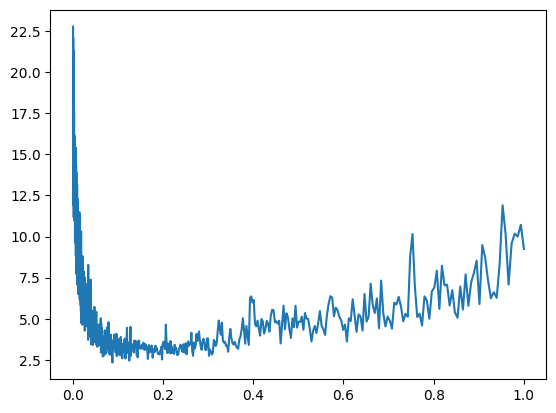

In [217]:
# track the learning rates in respect to its loss
lr_i = []
loss_i = []

for i in range(1000):

    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # 32 random integers between 0 and X.shape[0]. this will make the batch size 32

    # forward pass
    emb = C[X[ix]] # instead of sending the entire X for mapping, we can only iterate over the batch size
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) # labels are also only for the batch size too
    print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data.add_(-lr * p.grad)

    lr_i.append(lr)
    loss_i.append(loss.item())

plt.plot(lr_i, loss_i)

as you can see the learning rate was stable between 0.0 and 0.1, and after that it became unstable. So we have narrowed down the learning rate's range in respect to minimized loss function. So we can choose 0.1 safely now and also increase the iteration.

In [218]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [219]:
for i in range(10000):

    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # 32 random integers between 0 and X.shape[0]. this will make the batch size 32

    # forward pass
    emb = C[X[ix]] # instead of sending the entire X for mapping, we can only iterate over the batch size
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) # labels are also only for the batch size too
    # print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data.add_(-0.1 * p.grad)

In [220]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print('loss -> ', loss.item())

loss ->  2.491891860961914


#### Learning Rate Decay

One more thing to remember is that, once we found our optimized learning rate, we can run the training with it a few times. But then you realize the loss is not moving lower by much. In that case, on a trained NN, you can further reduce the learning rate, by a factor of 10, and continue thee training with same amount of iterations. You can continue this until you reach a plateau. This approach is called learning decay.

#### Data Split - Train/Validate/Test

If you increase your parameters to exceed your input size, you will end up over-fitting the data. Meaning that, your NN will memorize the data and outputs exactly what it saw, rather then being creative and output something new. 

To make sure we are not over-fitting or under-fitting we can split the data into training (80%), validation/dev (10%), and testing sets (10%). 

Validation is used to find the best hyper-params and settings of the NN. You can try multiple variations to evaluate which one is best for your data.

#### Code Wrap-up

In [221]:
# build the vocabulary of chars and mappings to/from integers
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i,s in enumerate(chars)}
s2i['.'] = 0
i2s = {i:s for s,i in s2i.items()}
vocab_size = len(i2s)

# MPL model
n_emb = 10 # the dimension of the character embedding vector
n_hidden = 200 # The number of neurons in the hidden layer of MLP
block_size = 3 # context length: how many chars do we take to predict the next char, 4-th one

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),                generator=g, requires_grad=True)
W1 = torch.randn((n_emb * block_size, n_hidden),    generator=g, requires_grad=True)
b1 = torch.randn((n_hidden),                        generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size),            generator=g, requires_grad=True)
b2 = torch.randn((vocab_size),                      generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [222]:
# build the dataset

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s2i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# split the dataset randomly for train, dev and test
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words)) # 80% of the words
n2 = int(0.9 * len(words)) # 90% of the words

Xtr, Ytr = build_dataset(words[:n1]) # train on 80% of the words
Xdev, Ydev = build_dataset(words[n1:n2]) # validate on 10% of the words
Xtst, Ytst = build_dataset(words[n2:]) # test on 10% of the words

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [223]:
max_steps = 200000
batch_size = 32
lossi = []

def train_NN(X,Y):
    
    for i in range(max_steps):

        # mini-batch
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g) # 32 random integers between 0 and X.shape[0]. this will make the batch size 32

        # forward pass
        emb = C[X[ix]] # instead of sending the entire X for mapping, we can only iterate over the batch size
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Y[ix]) # labels are also only for the batch size too
        # print('loss -> ', loss.item())

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay after 100k steps
        for p in parameters:
            p.data.add_(-lr * p.grad)

        # track stats
        if i % 1000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

@torch.no_grad()
def getLoss(X,Y):
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print('loss -> ', loss.item())            

In [224]:
# train
train_NN(Xtr, Ytr)


      0/ 200000: 27.8817
   1000/ 200000: 4.2208
   2000/ 200000: 2.9934
   3000/ 200000: 2.9829
   4000/ 200000: 2.2823
   5000/ 200000: 2.4180
   6000/ 200000: 2.4152
   7000/ 200000: 2.8149
   8000/ 200000: 2.5133
   9000/ 200000: 2.5542
  10000/ 200000: 2.8619
  11000/ 200000: 2.0939
  12000/ 200000: 2.4401
  13000/ 200000: 2.4719
  14000/ 200000: 2.9341
  15000/ 200000: 2.3488
  16000/ 200000: 2.6091
  17000/ 200000: 2.7315
  18000/ 200000: 2.4622
  19000/ 200000: 2.4676
  20000/ 200000: 2.5443
  21000/ 200000: 2.6354
  22000/ 200000: 2.1334
  23000/ 200000: 2.2140
  24000/ 200000: 3.0568
  25000/ 200000: 2.3262
  26000/ 200000: 2.5554
  27000/ 200000: 2.6473
  28000/ 200000: 2.3433
  29000/ 200000: 3.2092
  30000/ 200000: 2.8801
  31000/ 200000: 2.6749
  32000/ 200000: 2.5013
  33000/ 200000: 2.5535
  34000/ 200000: 2.1968
  35000/ 200000: 2.5608
  36000/ 200000: 2.1742
  37000/ 200000: 2.2611
  38000/ 200000: 2.9491
  39000/ 200000: 2.2258
  40000/ 200000: 2.0870
  41000/ 200000

if the loss of the training dataset and validation set are too different, that means that our NN hasn't learned much.

To visualize how the embeddings change after randomly setting them up and training the NN, run below code.

In [225]:
# training data loss
getLoss(Xtr, Ytr)
# validation loss
getLoss(Xdev, Ydev)


loss ->  2.1294455528259277
loss ->  2.173779249191284


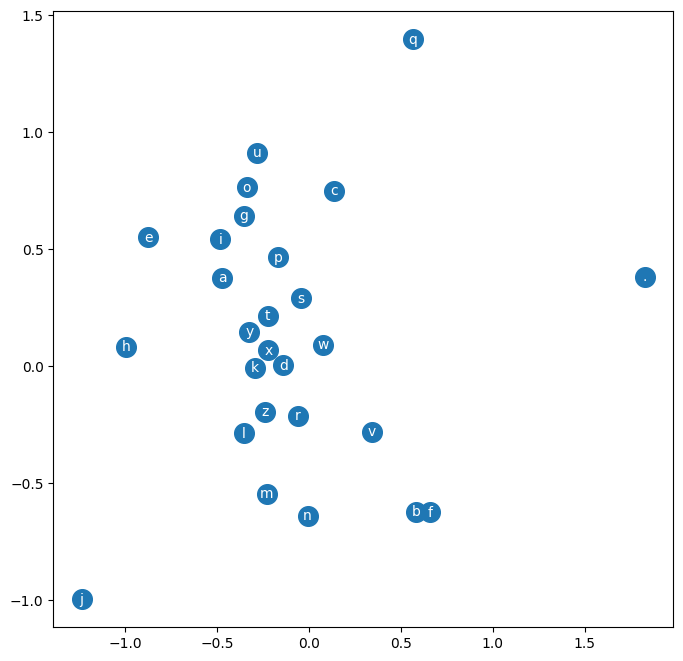

In [226]:
# plot the embeddings

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), i2s[i], ha='center', va='center', color='white')

In [227]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 1000)

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor([context])] 
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) 
        logits = h @ W2 + b2 
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: # stop at the end of the word
            break
    print(''.join(i2s[i] for i in out))


naitabree.
jaezi.
aje.
maxanley.
lei.
jacaraanly.
erilameenah.
ell.
adalisa.
ere.


at this point you can start working on the possible configuration tunings and improve your loos and validations.